# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation  
from keras.models import Sequential, load_model  # Sequential is for adding layers while load_model loads the saved model 
from keras.optimizers import Adam  # Adam is a type of optimizer used to modify weights of network to improve efficiency
import numpy as np

# Class Replay Buffer

In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size                                                
        self.mem_cnt = 0                                                        # self.memory.mem.cnt counts the no. of experiences that has been appended in replay memory    
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cnt % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cnt += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cnt, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

# Construction of Neural Network

In [3]:
def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential()
    model.add(Dense(units=fc1_dims, input_shape=(input_dims,), activation="relu"))
    model.add(Dense(units=fc2_dims, activation="relu"))
    model.add(Dense(n_actions, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(learning_rate = lr))
    return model

# Class Agent

In [4]:
class DDQNAgent(object):
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.06,
                 mem_size=1000000, filename='ddqn_model', replace_target=100):
        self.action_space = [i for i in range(n_actions)]                # 3 types of actions : 0 - hold, 1 - buy, 2 - sell
        self.n_actions = n_actions
        self.gamma = gamma                                               # discount factor that give certain value to future rewards
        self.eps = epsilon                                               # limit of exploration
        self.eps_dec = epsilon_dec                                       # decay rate of epsilon
        self.eps_min = epsilon_end                                       # min. value of epsilon
        self.batch_size = batch_size                                     # batch size i.e. input sample size for dqn to datermine state-action values 
        self.model_file = filename                                       # file name where trained model is saved 
        self.rep_target = replace_target                                 # integer which determines the criteria for coping weights 
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,      # obejct created to store experiences
                                   discrete=True)
        self.q_eval = build_dqn(lr, n_actions, input_dims, 121, 121)     # dq network to find state-action values 
        self.q_target = build_dqn(lr, n_actions, input_dims, 121, 121)   #2nd dq network to find optimal state action values with the help of copied weights of 1st dq network

    def remember(self, state, action, reward, new_state, done):          # function to store complete experience in replay memory
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]                                    
        rand = np.random.random()                                        # takes random floating value between 0 to 1
        if rand < self.eps:
            action = np.random.choice(self.action_space)                 # takes any action randomly from available actions i.e. {0,1,2}
        else:
            actions = self.q_eval.predict(state)                         # gives state-action values for every action in current state
            action = np.argmax(actions)                                  # chooses action which has max. value of state action value

        return action

    def learn(self):
        if self.memory.mem_cnt > self.batch_size:
            state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)     
            # sample_buffer gives a random sample of batchsize(no. of) state,action taken, reward received, new state and episode end info 

            action_values = np.array(self.action_space, dtype=np.int8)   
            action_indices = np.dot(action, action_values)
            # print(action_indices,"a")

            q_next = self.q_target.predict(new_state)                   # calculates q(s',a')
            q_eval = self.q_eval.predict(new_state)
            q_pred = self.q_eval.predict(state)                         # calculates q(s,a)

            max_actions = np.argmax(q_eval, axis=1)                     # forms an array of actions which give max value of q(s',a') among all possible actions of random choosen states

            q_target = q_pred

            batch_index = np.arange(self.batch_size, dtype=np.int32)    # forms array consisting elements from 1 to batch size

            q_target[batch_index, action_indices] = reward + self.gamma*q_next[batch_index, max_actions.astype(int)]*done    
            # implementing Bellman equation to find optimal q(s,a)

            _ = self.q_eval.fit(state, q_target, verbose=0)                                      # trains 1st dq network 

            self.eps = self.eps * self.eps_dec if self.eps > self.eps_min else self.eps_min      # modifies the value of epsilon periodically
            if self.memory.mem_cnt % self.rep_target == 0:                                
                self.update_network_parameters()
                # print(action_indices,"h")

    def update_network_parameters(self):                                        # function to update parameters of target dq network
        self.q_target.set_weights(self.q_eval.get_weights())                    # get_weights takes the weights of eval dq network while set_weights copies them over target dq network

    def save_model(self):                                                       # function to save the trained model
        self.q_eval.save(self.model_file)

    def load_model(self ):                                                      # loads a trained model for evaluation
        self.q_eval = load_model(self.model_file)                               
        
        if self.eps == 0.0:
            self.update_network_parameters()

# Function for Graph Ploting

In [5]:
import matplotlib.pyplot as plt

def plotLearning(x, profits, epsilons, filename, lines=None):
    fig=plt.figure()
    G1=fig.add_subplot(111, label="1")
    G2=fig.add_subplot(111, label="2", frame_on=False)

    G1.plot(x, epsilons, color="C0")
    G1.set_xlabel("Episode", color="C0")
    G1.set_ylabel("Epsilon", color="C0")
    G1.tick_params(axis='x', colors="C0")
    G1.tick_params(axis='y', colors="C0")

    N = len(profits)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(profits[max(0, t-20):(t+1)])

    G2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    G2.axes.get_xaxis().set_visible(False)
    G2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    G2.set_ylabel('Profit', color="C1")
    #ax2.xaxis.set_label_position('top')
    G2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    G2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

# Import Dataset

In [6]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/lovekvar/Summer-Project-over-q--learning-in-Finance/main/CSCO.csv",parse_dates=["Date"],index_col = "Date")
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,16.410000,17.000000,16.250000,16.959999,12.505757,40980600
2009-01-05,16.850000,17.299999,16.750000,17.110001,12.616367,45480200
2009-01-06,17.330000,17.980000,17.260000,17.790001,13.117774,58256600
2009-01-07,17.370001,17.580000,17.110001,17.320000,12.771208,50246600
2009-01-08,17.230000,17.570000,17.000000,17.540001,12.933430,46484600


In [7]:
train = data["2009-01-01":"2017-12-31"]
print(train.head())
print(train.tail())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2009-01-02  16.410000  17.000000  16.250000  16.959999  12.505757  40980600
2009-01-05  16.850000  17.299999  16.750000  17.110001  12.616367  45480200
2009-01-06  17.330000  17.980000  17.260000  17.790001  13.117774  58256600
2009-01-07  17.370001  17.580000  17.110001  17.320000  12.771208  50246600
2009-01-08  17.230000  17.570000  17.000000  17.540001  12.933430  46484600
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-12-22  38.520000  38.740002  38.470001  38.549999  34.404850  11441600
2017-12-26  38.549999  38.680000  38.360001  38.480000  34.342373   8186100
2017-12-27  38.540001  38.650002  38.450001  38.560001  34.413773  10543000
2017-12-28  38.730000  38.730000  38.450001  38.590000  34.440544   8807700
2017-12-29  

In [8]:
train = train['Close']
train

Date
2009-01-02    16.959999
2009-01-05    17.110001
2009-01-06    17.790001
2009-01-07    17.320000
2009-01-08    17.540001
                ...    
2017-12-22    38.549999
2017-12-26    38.480000
2017-12-27    38.560001
2017-12-28    38.590000
2017-12-29    38.299999
Name: Close, Length: 2265, dtype: float64

In [9]:
data = data['Close']

In [10]:
test = data["2018-01-01":"2019-12-31"]
print(test.head())
print(test.tail())

Date
2018-01-02    38.860001
2018-01-03    39.169998
2018-01-04    38.990002
2018-01-05    39.529999
2018-01-08    39.939999
Name: Close, dtype: float64
Date
2019-12-23    48.099998
2019-12-24    47.779999
2019-12-26    47.849998
2019-12-27    47.770000
2019-12-30    47.590000
Name: Close, dtype: float64


In [11]:
test.index[0]

Timestamp('2018-01-02 00:00:00')

# Traning our model

Streaming output truncated to the last 5000 lines.
2016-02-26 00:00:00 BUY
2016-02-29 00:00:00 BUY
2016-03-01 00:00:00 SELL
2016-03-02 00:00:00 BUY
2016-03-03 00:00:00 SELL
2016-03-04 00:00:00 BUY
2016-03-07 00:00:00 SELL
2016-03-08 00:00:00 SELL
2016-03-09 00:00:00 SELL
2016-03-10 00:00:00 BUY
2016-03-11 00:00:00 BUY
2016-03-14 00:00:00 BUY
2016-03-15 00:00:00 SELL
2016-03-16 00:00:00 BUY
2016-03-17 00:00:00 SELL
2016-03-18 00:00:00 BUY
2016-03-21 00:00:00 BUY
2016-03-22 00:00:00 BUY
2016-03-23 00:00:00 SELL
2016-03-24 00:00:00 SELL
2016-03-28 00:00:00 BUY
2016-03-29 00:00:00 BUY
2016-03-30 00:00:00 SELL
2016-03-31 00:00:00 SELL
2016-04-01 00:00:00 SELL
2016-04-04 00:00:00 BUY
2016-04-05 00:00:00 BUY
2016-04-06 00:00:00 SELL
2016-04-07 00:00:00 SELL
2016-04-08 00:00:00 BUY
2016-04-11 00:00:00 BUY
2016-04-12 00:00:00 SELL
2016-04-13 00:00:00 BUY
2016-04-14 00:00:00 BUY
2016-04-15 00:00:00 BUY
2016-04-18 00:00:00 SELL
2016-04-19 00:00:00 BUY
2016-04-20 00:00:00 BUY
2016-04-21 00:00:00 S

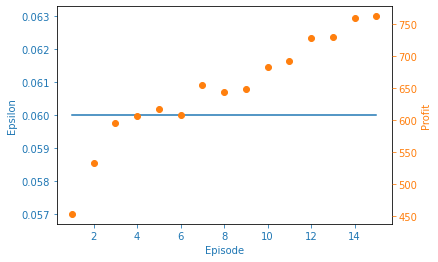

In [11]:
max_transactions = 100
total_money = 2500
current_transaction_count = 0
ddqn_scores = []
ddqn_profits = []
eps_history = []
num_episodes = 15
l = len(train) -1
# l = 500
ddqn_agent = DDQNAgent(lr=0.001, gamma=0.9, n_actions=3, epsilon=1.0,
                  batch_size=64, input_dims=11)
u = v = -2

for e in range(num_episodes):
    # done = False
    score = 0
    vect = [ 0. for i in range(24)]
    state = [10000,0,max_transactions,total_money,current_transaction_count,0,0,0,0,0,0]
    state = np.array(state)
    total_profit = 0
    buy = []
    for t in range(l):
        action = ddqn_agent.choose_action(state)
        profit = 0
        # reward =  0

        if action ==1 and current_transaction_count < max_transactions and t > 0:
            print(train.index[t],"BUY")
            x = total_money/(max_transactions - current_transaction_count)
            current_stocks_buy = x/train[t-1]
            total_money -= train[t]*current_stocks_buy 
            b = [train[t],current_stocks_buy]
            buy.append(b)
            current_transaction_count += 1
            if len(buy) == 0 :
                reward = 2
            elif min(buy)[0] < train[t]:
                reward = - min(buy)[1] * ( train[t] - min(buy)[0] )
            else:
                reward = 2
            # reward = (train[t]*current_stocks_buy - x )/x
            # if train[t-1] > train[t]:
            #     reward = 0.4
            # elif len(buy) > 0 and min(buy)[0] < train[t]:
            #     reward = -0.4 
            
        elif ( action == 2 and len(buy) > 0 ) or ( action == 1 and len(buy) > 0):
            action = 2
            print(train.index[t],"SELL")
            current_transaction_count = 0
            buy.sort()
            reward = buy[0][1] * (train[t] - buy[0][0] )
            total_money += buy[0][1] * train[t]
            buy.pop(0)
            while len(buy) > 0 and buy[0][0] < train[t] :
                reward += ( buy[0][1] * (train[t] - buy[0][0] ) )
                total_money += buy[0][1] * train[t]
                buy.pop(0)

            profit = reward
            # if t == (u+1) and reward < 0:
            #     reward = 2*reward
            # u = t

        else :
            print(train.index[t],"HOLD")
            action = 0
            if len(buy) == 0:
                reward = -5
            elif min(buy)[0] < train[t]:
                buy.sort()
                for i in range(len(buy)):
                    if buy[i][0] > train[t]:
                        break
                    reward += ( buy[i][1] * (train[t] - buy[i][0] ) )

                reward = - max(reward,5)
            else:
                reward = 0.05
            if t == (v+1) and reward < 0:
                reward = 2*reward 
            v = t


        new_state = [10000,train[t],max_transactions,total_money,current_transaction_count]
        if(len(buy) > 0):
            new_state[0] = min(buy)[0]
        vect.pop(0)
        vect.append(train[t])
        for i in range(0,24,4):
            x = 0.
            for j in range(i,(i+4)) :
                x += vect[j]
            new_state.append(x/4)
        new_state = np.array(new_state)

        score += reward
        total_profit += profit
        ddqn_agent.remember(state, action, reward, new_state, int(0))
        state = new_state
        ddqn_agent.learn()

    eps_history.append(ddqn_agent.eps)
    ddqn_scores.append(score)
    ddqn_profits.append(total_profit)

    avg_score = np.mean(ddqn_scores[max(0, e-100):(e+1)])
    avg_profit = np.mean(ddqn_profits[max(0, e-100):(e+1)])
    print('\n\nepisode: ', e+1,'score: %.2f' % score,' average score %.2f' % avg_score)
    print('total profit: %.2f' % total_profit,' average profit %.2f' % avg_profit,'\n\n')

    if (e+1) % 3 == 0 and e > 0:
        ddqn_agent.save_model()

filename = 'stock prediction-ddqn.png'

x = [i+1 for i in range(num_episodes)]
plotLearning(x, ddqn_profits, eps_history, filename)








Orange dots are showing the average profits v/s episode passed while training the ddqn_agent

some error occured in epsilon curve in graph as epsilon reached its min. value before completing its first episode. This happened because of large training data.
However, we can get correct graph by changing some parameters like eps_decay. I am not showing the correct graph for epsilon curve as it would again take atleast 2 hours to train the model.  

# Model Evaluation

Due to gpu usage limit constraint, I am not able to make slight change in code to possibly increase the profit while evaluation. These code lines are marked with '@'.

In [22]:
max_transactions = 100
total_money = 2500
current_transaction_count = 0
model2 = tf.keras.models.load_model('ddqn_model')
# eps = 0.06 @
vect = []
for i in range(-24,0,1):
    vect.append(train[i])
score = 0
state = [10000,0,max_transactions,total_money,current_transaction_count]
for i in range(0,24,4):
    x = 0.
    for j in range(i,(i+4)) :
        x += vect[j]
    state.append(x/4)
state = np.array(state)
# print(state.shape)
total_profit = 0
buy = []

for t in range(len(test)):
    # rand = np.random.random() @
    # if rand < eps : @
    #     action = np.random.choice([0,1,2]) @
    # else : @
    actions = model2.predict(state.reshape(1,11))
    action = np.argmax(actions)
    profit = 0

    if action ==1 and current_transaction_count < max_transactions:
        print(test.index[t],"BUY")
        x = total_money/(max_transactions - current_transaction_count)
        current_stocks_buy = x/vect[23]
        total_money -= test[t]*current_stocks_buy 
        b = [test[t],current_stocks_buy]
        buy.append(b)
        current_transaction_count += 1
        if len(buy) == 0 :
            reward = 0.8
        elif min(buy)[0] < test[t]:
            reward = - min(buy)[1] * ( test[t] - min(buy)[0] )
        else:
            reward = 0.4
            
    elif ( action == 2 and len(buy) > 0 ) or ( action == 1 and len(buy) > 0):
        action = 2
        print(test.index[t],"SELL")
        current_transaction_count = 0
        buy.sort()
        reward = buy[0][1] * (test[t] - buy[0][0] )
        total_money += buy[0][1] * test[t]
        buy.pop(0)
        while len(buy) > 0 and buy[0][0] < test[t] :
            reward += ( buy[0][1] * (test[t] - buy[0][0] ) )
            total_money += buy[0][1] * test[t]
            buy.pop(0)

        profit = reward

    else :
        print(test.index[t],"HOLD")
        action = 0
        if len(buy) == 0:
            reward = -1
        elif min(buy)[0] < test[t]:
            buy.sort()
            for i in range(len(buy)):
                if buy[i][0] > test[t]:
                    break
                reward += ( buy[i][1] * (test[t] - buy[i][0] ) )

            reward = - reward
        else:
            reward = 0.2

    new_state = [10000,test[t],max_transactions,total_money,current_transaction_count]
    if(len(buy) > 0):
        new_state[0] = min(buy)[0]
    vect.pop(0)
    vect.append(train[t])
    for i in range(0,24,4):
        x = 0.
        for j in range(i,(i+4)) :
            x += vect[j]
        new_state.append(x/4)
    new_state = np.array(new_state)

    score += reward
    total_profit += profit
    state = new_state

print('score: %.2f' % score)
print('total profit: %.2f' % total_profit)


2018-01-02 00:00:00 BUY
2018-01-03 00:00:00 SELL
2018-01-04 00:00:00 BUY
2018-01-05 00:00:00 BUY
2018-01-08 00:00:00 SELL
2018-01-09 00:00:00 BUY
2018-01-10 00:00:00 BUY
2018-01-11 00:00:00 SELL
2018-01-12 00:00:00 BUY
2018-01-16 00:00:00 BUY
2018-01-17 00:00:00 SELL
2018-01-18 00:00:00 BUY
2018-01-19 00:00:00 BUY
2018-01-22 00:00:00 SELL
2018-01-23 00:00:00 BUY
2018-01-24 00:00:00 BUY
2018-01-25 00:00:00 SELL
2018-01-26 00:00:00 BUY
2018-01-29 00:00:00 BUY
2018-01-30 00:00:00 SELL
2018-01-31 00:00:00 BUY
2018-02-01 00:00:00 BUY
2018-02-02 00:00:00 SELL
2018-02-05 00:00:00 BUY
2018-02-06 00:00:00 SELL
2018-02-07 00:00:00 BUY
2018-02-08 00:00:00 SELL
2018-02-09 00:00:00 BUY
2018-02-12 00:00:00 SELL
2018-02-13 00:00:00 BUY
2018-02-14 00:00:00 SELL
2018-02-15 00:00:00 BUY
2018-02-16 00:00:00 SELL
2018-02-20 00:00:00 BUY
2018-02-21 00:00:00 BUY
2018-02-22 00:00:00 SELL
2018-02-23 00:00:00 BUY
2018-02-26 00:00:00 SELL
2018-02-27 00:00:00 BUY
2018-02-28 00:00:00 BUY
2018-03-01 00:00:00 SELL
